# FMCW Radar

This is a basic FMCW radar simulation example based on `RadarSimPy`.

>`RadarSimPy` is a radar simulation package built with python. **<a href="https://zpeng.me/#contact" target="_blank">Contact me</a> if you are interested in this module.**

This notebook is available on my <a href="https://github.com/rookiepeng/radar-simulation-notebooks" target="_blank">GitHub</a>.


## Radar Model
### Transmitter

The following table lists the basic parameters of the radar transmitter.

 | Parameter                       | Variable in `RadarSimPy` | Value      |
 |---------------------------------|--------------------------|------------|
 | Center frequency ($f_c$)        | fc                       | 24.125 GHz |
 | Bandwidth ($B$)                 | bandwidth                | 100 MHz    |
 | Transmitted power ($P_t$)       | tx_power                 | 10 dBm     |
 | Rising or falling chirp         | slop_type                | rising     |
 | Chirp repetition period ($CRP$) | repetition_period        | 100 us     |
 | Chirp length ($T$)              | pulse_length             | 80 us      |
 | Number of chirps                | pulses                   | 256        |
 | Chirp start delay               | delay                    | 0 s        |

The radiation pattern os the transmitter antenna is $\cos{\theta}$. The gain of the antenna is 6 dB.


In [1]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

angle = np.arange(-90, 91, 1)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01) + 6

tx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)

tx = Transmitter(f=[24.075e9, 24.175e9],
                 t=80e-6,
                 tx_power=10,
                 prp=100e-6,
                 pulses=256,
                 channels=[tx_channel])

 ### Receiver
 The parameters of the receiver are listed in the table below.

 | Parameter                        | Variable in `RadarSimPy` | Value        |
 |----------------------------------|--------------------------|--------------|
 | Sampling rate ($f_s$)            | fs                       | 2 Msps       |
 | Noise figure ($NF$)              | noise_figure             | 12 dB        |
 | RF gain/loss ($G_{rf}$)          | rf_gain                  | 20 dB        |
 | Load resistor ($R_L$)            | load_resistor            | 500 $\Omega$ |
 | Baseband voltage gain ($G_{BB}$) | baseband_gain            | 30 dB        |

 The radiation pattern os the receiver antenna is $\cos{\theta}$. The gain of the antenna is 6 dB.

In [2]:
rx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=angle,
    azimuth_pattern=pattern,
    elevation_angle=angle,
    elevation_pattern=pattern,
)

rx = Receiver(fs=2e6,
              noise_figure=12,
              rf_gain=20,
              load_resistor=500,
              baseband_gain=30,
              channels=[rx_channel])

 Create the FMCW radar model based on all the parameters defined above.

In [3]:
radar = Radar(transmitter=tx, receiver=rx)

 Calculate the characteristics of the FMCW radar:

 - Maximum range (*with I/Q baseband*): $$R_{max}=\frac{c f_s T}{2B}$$

 - Maximum range (*without I/Q baseband*): $$R_{max}=\frac{c f_s T}{4B}$$

 - Unambiguous velocity: $$v_{ua}=\frac{c}{2 CRP \times f_c}$$ or $$v_{ua}=\pm \frac{c}{4 CRP \times f_c}$$

 - Range resolution: $$\delta_r=\frac{c}{2B}$$


In [4]:
print('Maximum range: ', radar.max_range, ' m')
print('Maximum unambiguous speed: ', radar.unambiguous_speed, ' m/s')
print('Range_resolution: ', radar.range_resolution, ' m')

Maximum range:  239.83396640000004  m
Maximum unambiguous speed:  62.133151917098445  m/s
Range_resolution:  1.49896229  m


 ### Targets
 The propertities of targets are defined here. There are 3 targets in this simulation. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (radian).

In [5]:
target_1 = dict(location=(200, 0, 0), speed=(-5, 0, 0), rcs=20, phase=0)
target_2 = dict(location=(95, 20, 0), speed=(-50, 0, 0), rcs=15, phase=0)
target_3 = dict(location=(30, -5, 0), speed=(-22, 0, 0), rcs=5, phase=0)

targets = [target_1, target_2, target_3]

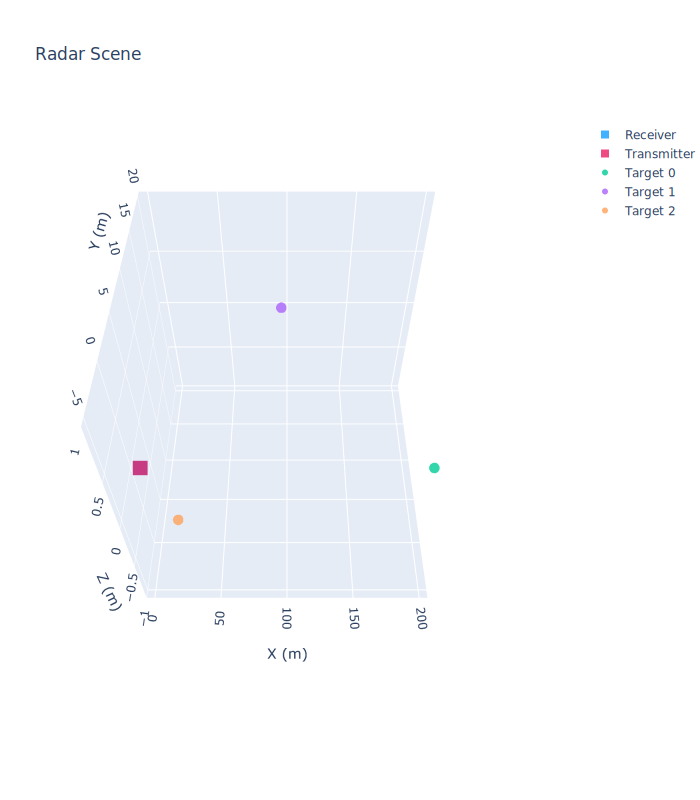

In [6]:
import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.display import SVG, display

rx_locations = radar.receiver.locations
tx_locations = radar.transmitter.locations

rx_axis = go.Scatter3d(
    x=rx_locations[:, 0],
    y=rx_locations[:, 1],
    z=rx_locations[:, 2],
    mode='markers',
    name='Receiver',
    marker=dict(color='rgb(17, 157, 255)',
                size=8,
                opacity=0.8,
                symbol='square'),
)

tx_axis = go.Scatter3d(
    x=tx_locations[:, 0],
    y=tx_locations[:, 1],
    z=tx_locations[:, 2],
    mode='markers',
    name='Transmitter',
    marker=dict(color='rgb(233, 30, 99)', size=8, opacity=0.8,
                symbol='square'),
)

data = [rx_axis, tx_axis]

for target_idx, target in enumerate(targets):
    target_loc = go.Scatter3d(
        x=[target['location'][0]],
        y=[target['location'][1]],
        z=[target['location'][2]],
        mode='markers',
        name='Target ' + str(target_idx),
        marker=dict(size=6, opacity=0.8),
    )
    data = data + [target_loc]

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=0, y=-1.5, z=1.8),
)

layout = go.Layout(
    title='Radar Scene',
    scene=dict(xaxis=dict(title='X (m)'),
               yaxis=dict(title='Y (m)'),
               zaxis=dict(title='Z (m)'),
               camera=camera,
               aspectmode='cube'),
    margin=dict(l=0, r=0, b=120, t=120),
    height=800,
)
fig = go.Figure(data=data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))

## Simulate Baseband Signals
 
Calculate baseband signal matrix:
$$[channel, slow~time, fast~time]$$
 
#### Simulate with Python engine

In [7]:
from radarsimpy import simulator as sim

data_py = sim(radar, targets)
time_matrix_py = data_py['timestamp']
data_matrix_py = data_py['baseband']

#### Simulate with C++ engine

In [8]:
from radarsimpy import simulatorcpp as simcpp

data_cpp = simcpp(radar, targets)
time_matrix_cpp = data_cpp['timestamp']
data_matrix_cpp = data_cpp['baseband']

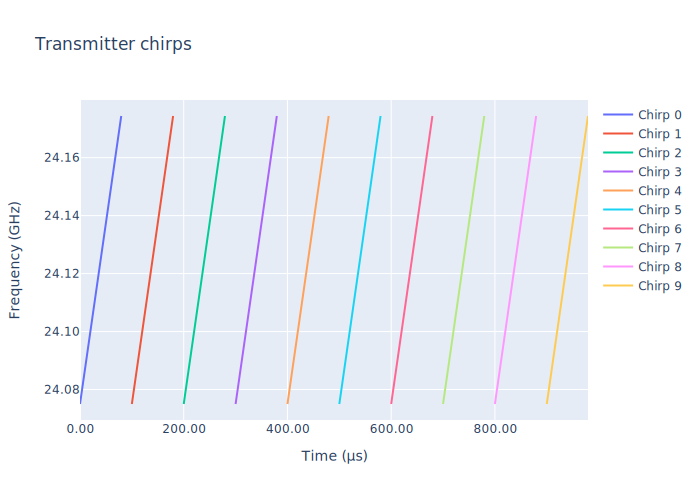

In [9]:
data = []
for idx in range(0, 10):
    chirp = go.Scatter(
        x=time_matrix_py[0, idx, :] * 1e6,
        y=np.linspace(
            radar.transmitter.fc_0 - radar.transmitter.bandwidth / 2,
            radar.transmitter.fc_0 + radar.transmitter.bandwidth / 2,
            radar.samples_per_pulse,
            endpoint=False,
        ) / 1e9,
        name='Chirp ' + str(idx),
    )
    data = data + [chirp]

layout = go.Layout(
    title='Transmitter chirps',
    yaxis=dict(tickformat='.2f', title='Frequency (GHz)'),
    xaxis=dict(tickformat='.2f', title='Time (µs)'),
)

fig = go.Figure(data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))

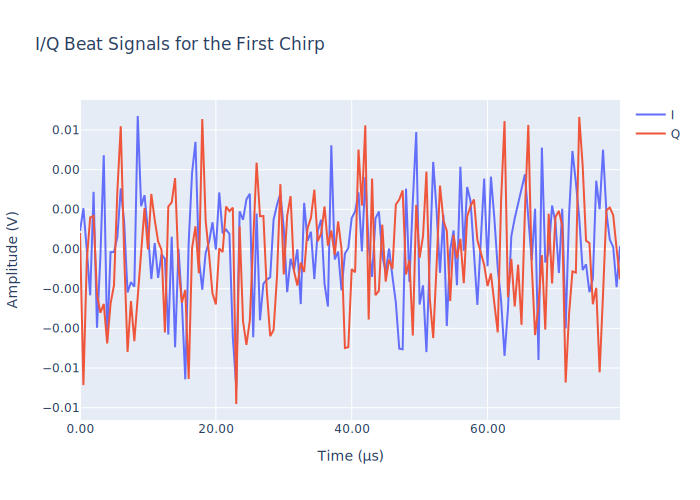

In [10]:
beat_I = go.Scatter(
    x=time_matrix_cpp[0, 0, :] * 1e6,
    y=np.real(data_matrix_cpp[0, 0, :]),
    name='I',
)
beat_Q = go.Scatter(
    x=time_matrix_cpp[0, 0, :] * 1e6,
    y=np.imag(data_matrix_cpp[0, 0, :]),
    name='Q',
)
data = [beat_I, beat_Q]

layout = go.Layout(
    title='I/Q Beat Signals for the First Chirp',
    yaxis=dict(tickformat='.2f', title='Amplitude (V)'),
    xaxis=dict(tickformat='.2f', title='Time (µs)'),
)

fig = go.Figure(data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))

 ## Radar Signal Processing
 ### Range profile

In [11]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.chebwin(radar.samples_per_pulse, at=60)
range_profile = proc.cal_range_profile(radar, data_matrix_cpp, range_window)

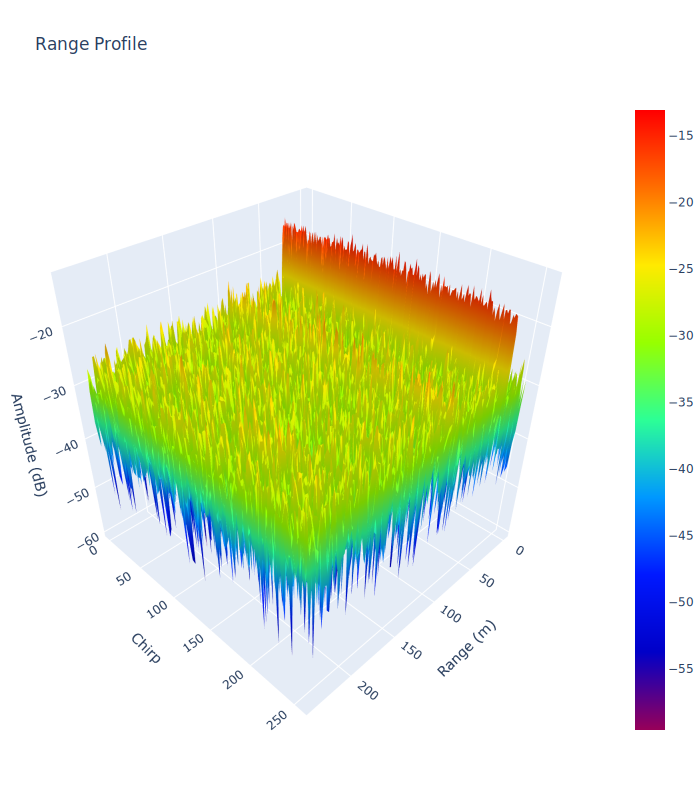

In [12]:
temp = np.abs(range_profile[0, :, :])
temp = 20 * np.log10(temp + 0.001)

range_axis = np.linspace(
    0, radar.max_range, radar.samples_per_pulse, endpoint=False)

doppler_axis = np.linspace(
    0, radar.transmitter.pulses, radar.transmitter.pulses, endpoint=False)

data = [go.Surface(x=range_axis, y=doppler_axis, z=temp, colorscale='Rainbow')]

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.4, y=1.4, z=1.4)
)

layout = go.Layout(
    title='Range Profile',
    height=800,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Chirp'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='cube',
        camera=camera,
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation='h'),
)

fig = go.Figure(data=data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))

 ### Range-Doppler processing

In [13]:
doppler_window = signal.chebwin(radar.transmitter.pulses, at=60)
range_doppler = proc.cal_range_doppler(
    radar, range_profile, doppler_window, fft_shift=False)

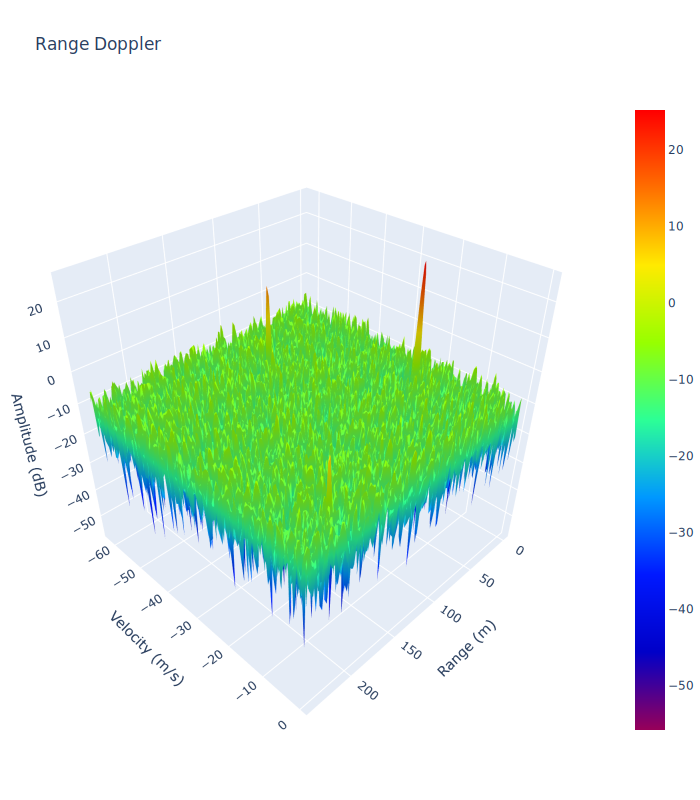

In [14]:
temp = np.abs(range_doppler[0, :, :])
temp = 20 * np.log10(temp)

range_axis = np.linspace(
    0, radar.max_range, radar.samples_per_pulse, endpoint=False)

doppler_axis = np.linspace(
    -radar.unambiguous_speed, 0, radar.transmitter.pulses, endpoint=False)

data = [go.Surface(x=range_axis, y=doppler_axis, z=temp, colorscale='Rainbow')]

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.4, y=1.4, z=1.4)
)

layout = go.Layout(
    title='Range Doppler',
    height=800,
    scene=dict(
        xaxis=dict(title='Range (m)'),
        yaxis=dict(title='Velocity (m/s)'),
        zaxis=dict(title='Amplitude (dB)'),
        aspectmode='cube',
        camera=camera,
    ),
    margin=dict(l=0, r=0, b=60, t=100),
    legend=dict(orientation='h'),
)

fig = go.Figure(data=data, layout=layout)
# iplot(fig)
display(SVG(fig.to_image(format='svg', scale=1)))